In [2]:
from itertools import combinations

import numpy as np
import numpy.typing as npt
import open3d as o3d
import open3d.core as o3c

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

from typing import List

from spectra import Spectra
from models import gaussian
from metamers import Cone, Observer

from scipy.spatial.distance import cdist

**Load Cone Data**

In [3]:
def remove_trailing_nans(arr):
    mask = np.any(np.isnan(arr), axis=1)
    idx = np.where(mask)[0]
    if idx.size > 0:
        last_valid_idx = np.where(~mask)[0][-1]
        return arr[:last_valid_idx + 1]
    return arr


In [4]:
cone_data = np.genfromtxt('linss2_10e_1.csv', delimiter=',')

s_cone = Cone(cone_data[:, [0, 1]])
m_cone = Cone(cone_data[:, [0, 2]])
l_cone = Cone(remove_trailing_nans(cone_data[:, [0, 3]]))

<IPython.core.display.Javascript object>


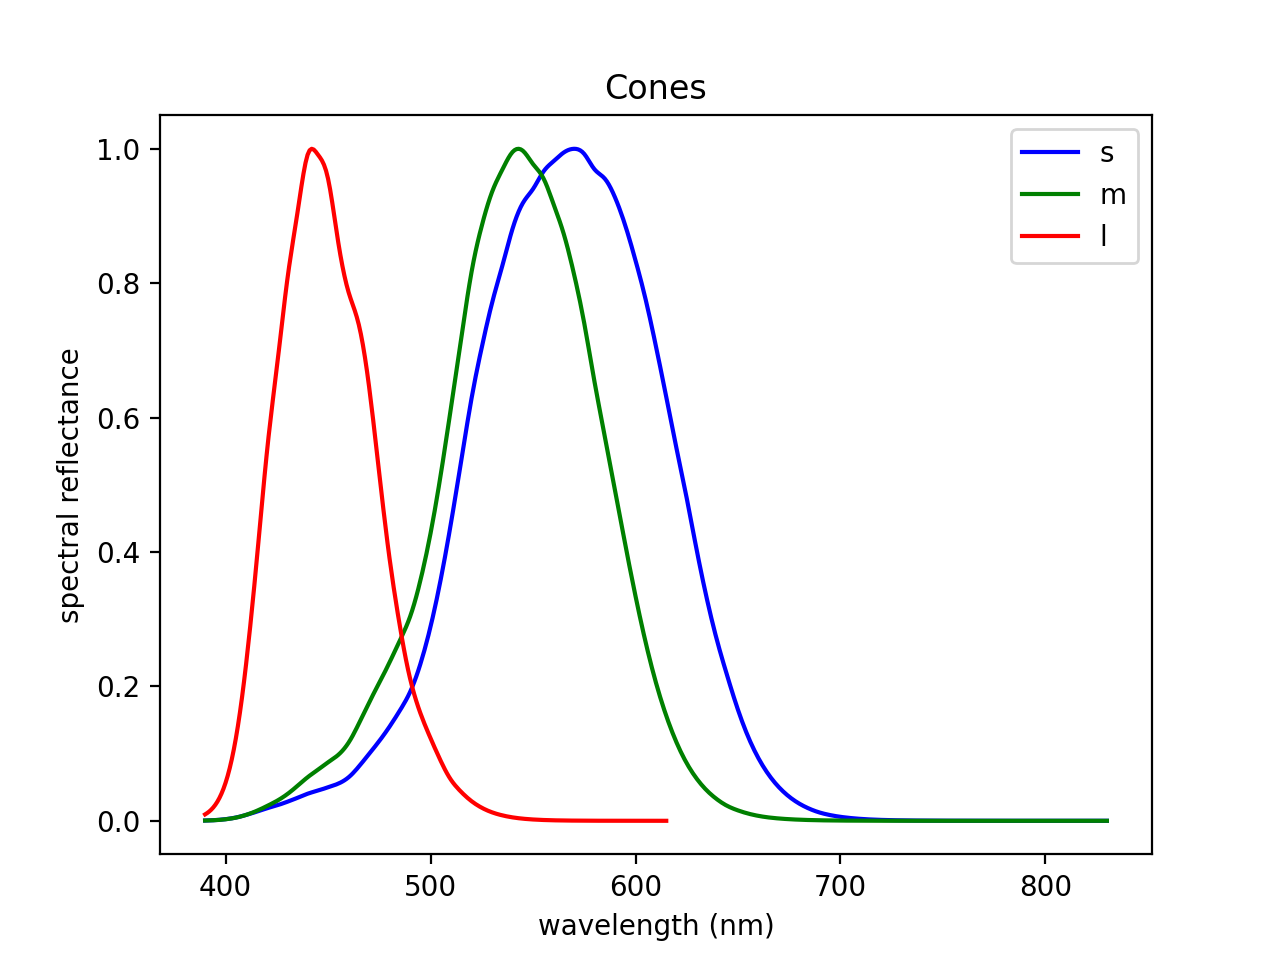

In [5]:
s_cone.plot(name="s", color="b")
m_cone.plot(name="m", color="g")
l_cone.plot(name="l", color="r")
plt.xlabel('wavelength (nm)')
plt.ylabel('spectral reflectance')
plt.title('Cones')
plt.legend()
plt.show()

**Visualize Trichromat Gamut Space**

<IPython.core.display.Javascript object>


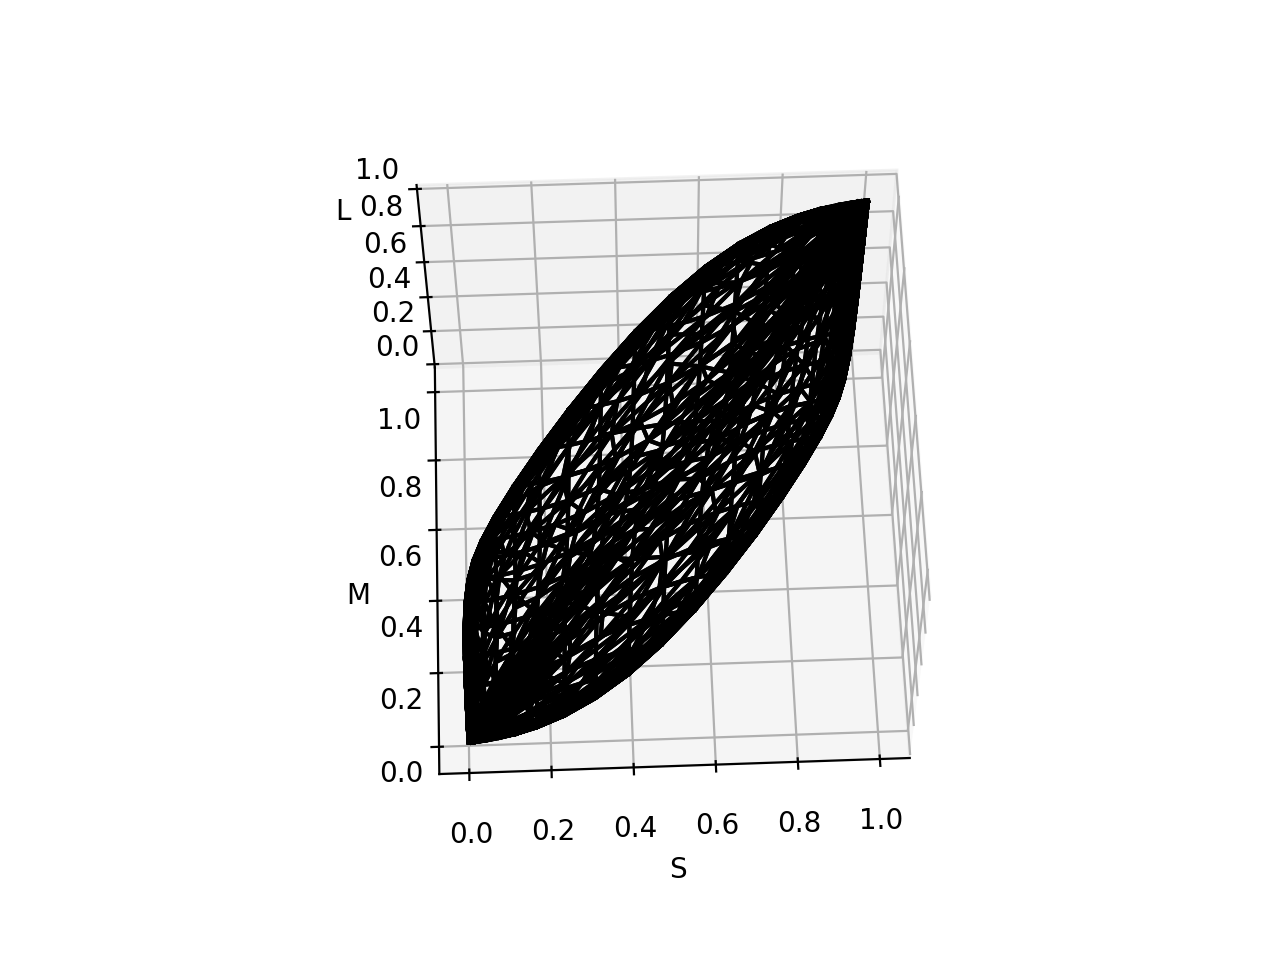

In [6]:
%matplotlib notebook

trichromat = Observer([s_cone, m_cone, l_cone], min_transition_size=10)
full_colors_3d = trichromat.get_full_colors().T  # M x 3

hull = ConvexHull(full_colors_3d)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel('S')
ax.set_ylabel('M')
ax.set_zlabel('L')


# Plot hull of the Gamut
for simplex in hull.simplices:
    s = simplex.astype(int)
    s = np.append(s, s[0]) 
    ax.plot(full_colors_3d[s,0], full_colors_3d[s,1], full_colors_3d[s,2], "k-")

plt.show()

**Open3d Visualization**
This will visualize the full point cloud using open3d. May or may not work for you.

In [8]:
points = o3c.Tensor(full_colors_3d)
pcd = o3d.t.geometry.PointCloud()

pcd.point.positions = points

hull = pcd.compute_convex_hull()

hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull.to_legacy())
hull_ls.paint_uniform_color((1, 0, 0))


o3d.visualization.draw_geometries([hull.to_legacy(), pcd.to_legacy()])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


**Obtaining highly contrastive colors**

First, we identify the plane of saturation furthest away from black and white. Here is my approach:

1. Define a saturation line that goes from the blackpoint to the whitepoint.
2. Find the plane orthogonal to this line that intersections the line at its midpoint -- approximately the thickest portion of the gamut.
3. Identify the intersection points of the plane and the boundary of the gamut.
4. Analyze the geometry of the resultant shape to find contrasting points/colors.

In [7]:
blackpoint = full_colors_3d[0]
whitepoint = full_colors_3d[1]

D = (whitepoint - blackpoint) / np.linalg.norm(whitepoint - blackpoint)  # plane normal
m = (whitepoint + blackpoint) / 2 # midpoint on ray (point on plane)

def intersects_plane(v1, v2, v3, normal, d):
    values = [np.dot(normal, v) + d for v in [v1, v2, v3]]

    if any(val > 0 for val in values) and any(val < 0 for val in values):
        return True
    return False

d = -np.dot(m, D)

intersection_indices = []

for simplex in hull.simplices:
    v1_idx, v2_idx, v3_idx = simplex
    v1, v2, v3 = [full_colors_3d[idx] for idx in [v1_idx, v2_idx, v3_idx]]

    if intersects_plane(v1, v2, v3, D, d):
        distances = [abs(np.dot(D, v) + d) for v in [v1, v2, v3]]

        closest_idx = np.argmin(distances)

        closest_vertex_idx = [v1_idx, v2_idx, v3_idx][closest_idx]
        intersection_indices.append(closest_vertex_idx)

intersection_indices = list(set(intersection_indices))

print(f"Found {len(intersection_indices)} unique points on the plane.")

Found 65 unique points on the plane.


Let's visualize the points we've found:

In [8]:
def index_to_rgb(index):
    transition = trichromat.get_transition(index)
    color = Spectra(wavelengths=trichromat.wavelengths, data=transition).to_rgb()

    return color 

In [9]:
intersection_points = full_colors_3d[intersection_indices]

colors = [index_to_rgb(idx) for idx in intersection_indices]

<IPython.core.display.Javascript object>


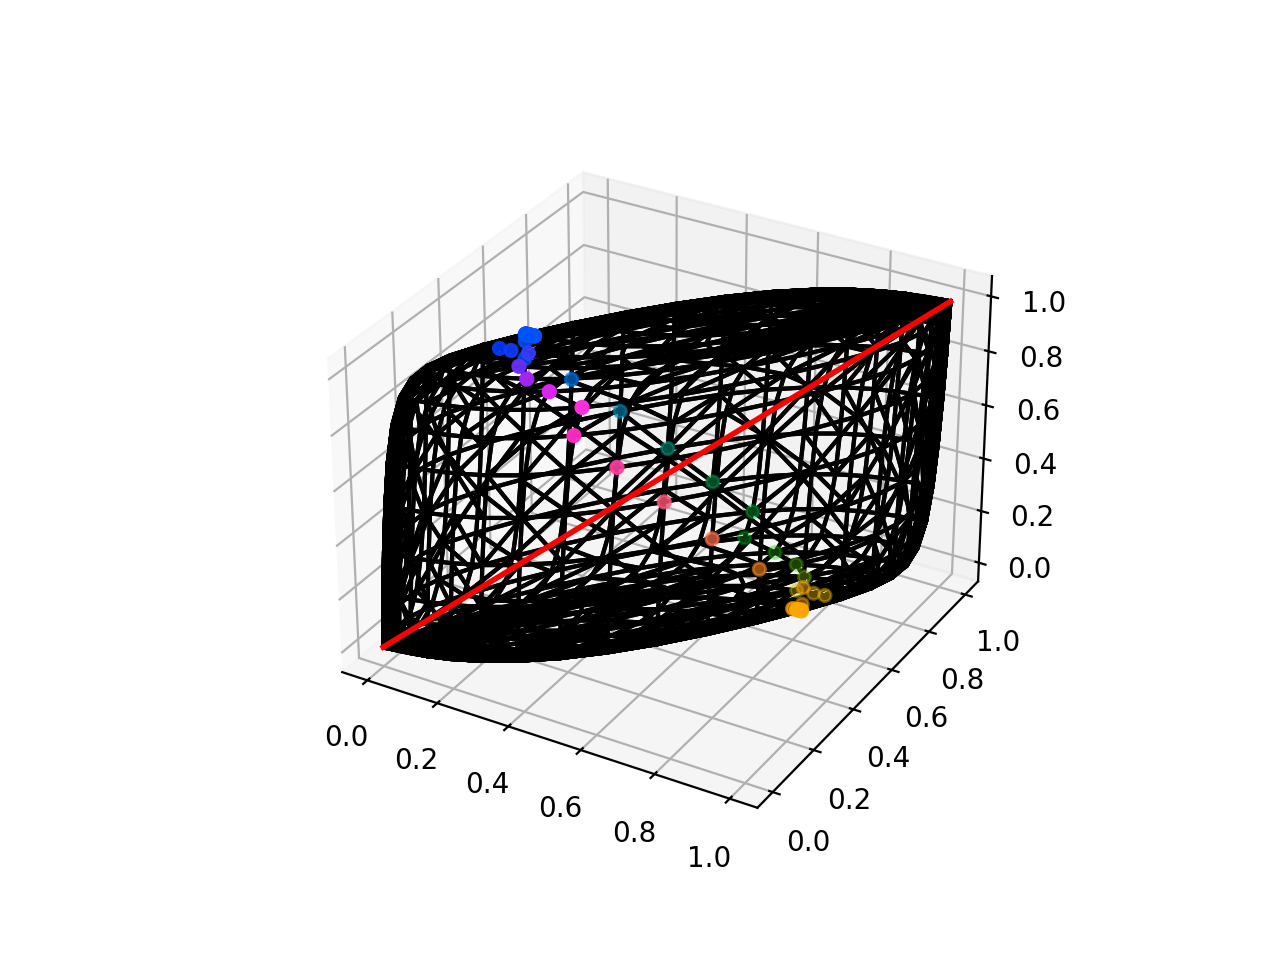

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

intersection_points = full_colors_3d[intersection_indices]

rgb_colors = [index_to_rgb(idx) for idx in intersection_indices]

rgb_colors = np.array(colors)

ax.scatter(intersection_points[:, 0], intersection_points[:, 1], intersection_points[:, 2], c=rgb_colors, marker='o')

for simplex in hull.simplices:
    s = simplex.astype(int)
    s = np.append(s, s[0])  
    ax.plot(full_colors_3d[s, 0], full_colors_3d[s, 1], full_colors_3d[s, 2], "k-")

ray_start = blackpoint
ray_end = whitepoint
ax.plot([ray_start[0], ray_end[0]], [ray_start[1], ray_end[1]], [ray_start[2], ray_end[2]], 'r-', lw=2, label='Ray')


plt.show()

It's a bit hard to see what's going on in the 3D diagram. Luckily, the intersection points lay on the plane so we can visualize this in 2D: 

<IPython.core.display.Javascript object>


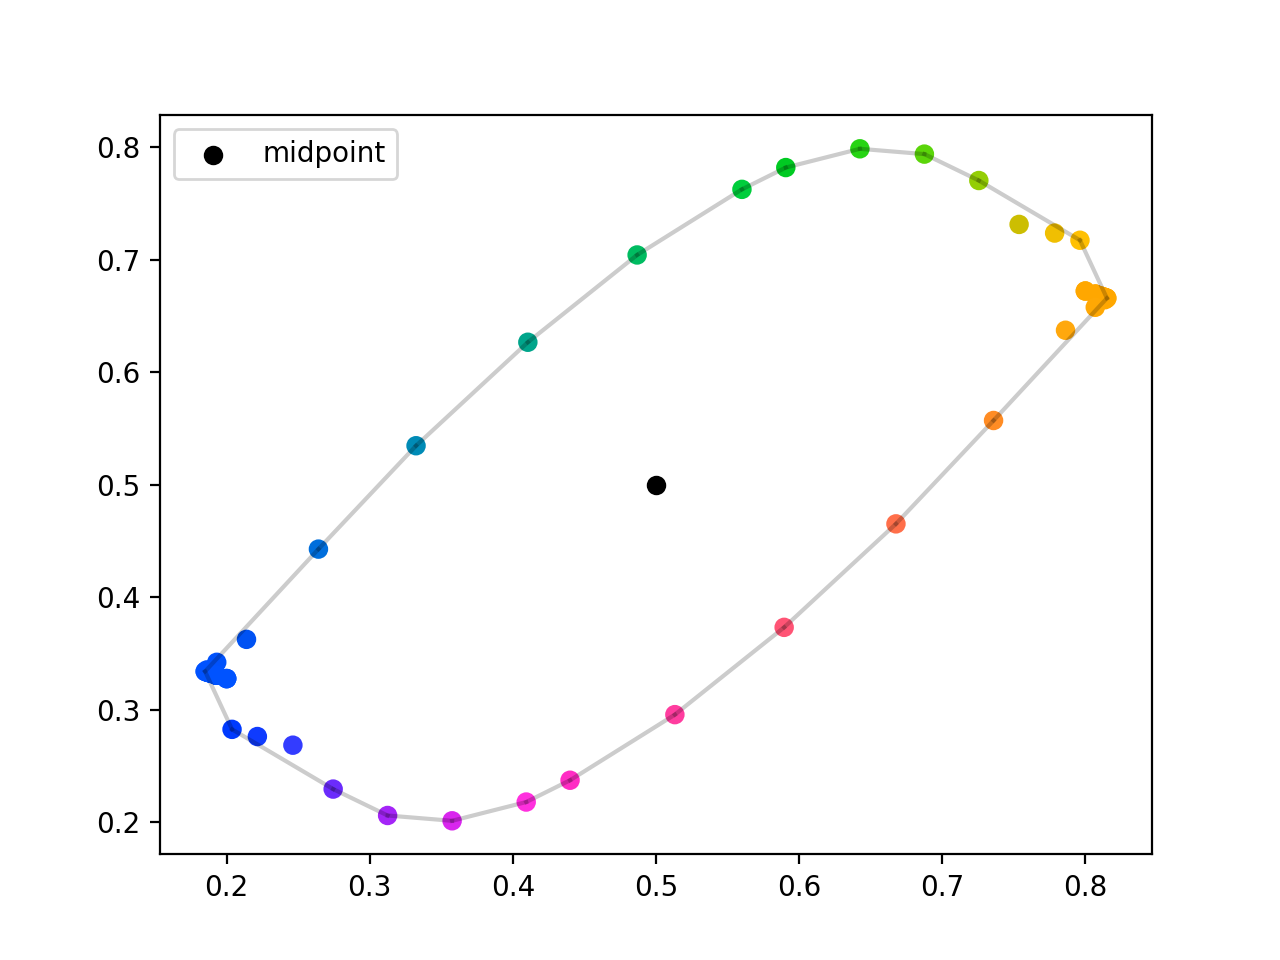

In [11]:
def project_point_to_plane(point, plane_normal, point_on_plane):
    d = np.dot(plane_normal, point - point_on_plane)
    return point - d * plane_normal

projected_points = np.array(
    [project_point_to_plane(p, D, m) for p in (intersection_points)]  
    
)

fig, ax = plt.subplots()

projected_x = projected_points[:, 0]  
projected_y = projected_points[:, 1]  

scatter = ax.scatter(projected_x, projected_y, c=rgb_colors)
hull2d = ConvexHull(np.column_stack((projected_x, projected_y)))
for simplex in hull2d.simplices:
    plt.plot(hull2d.points[simplex, 0], hull2d.points[simplex, 1], 'k-', alpha=0.2)
    
plt.scatter(0.5, 0.5, c='black', label="midpoint")
plt.legend()

plt.show()

This familiar layout is often seen as the boundary of a color wheel. 

These points correspond to the intersection of a the boundary of the gamut with a 2d plane. Therfore, they lay along a single line! Since the point cloud representation is discrete, this line does not look very smooth.

Our "highly contrastive colors" should be points that are opposite each other. The exact interpretation of this is a bit ambigious! 

To maximize the number of contrasting points, for now we will consider all points that are further apart from each other than they are from the midpoint. 

In [24]:
contrasting_pairs = []
for i in range(len(intersection_indices) - 1):
    c1 = full_colors_3d[intersection_indices[i]]
    mdpt_dist = np.linalg.norm(c1 - m)
    for j in range(i + 1, len(intersection_indices)):
        c2 = full_colors_3d[intersection_indices[j]]
        if np.linalg.norm(c1 - c2) > mdpt_dist:
            contrasting_pairs.append((i,j))
print(len(contrasting_pairs))

1184


**Finding 2D metamers**

Let us simulate Protanopia by eliminating the L cone.

<IPython.core.display.Javascript object>


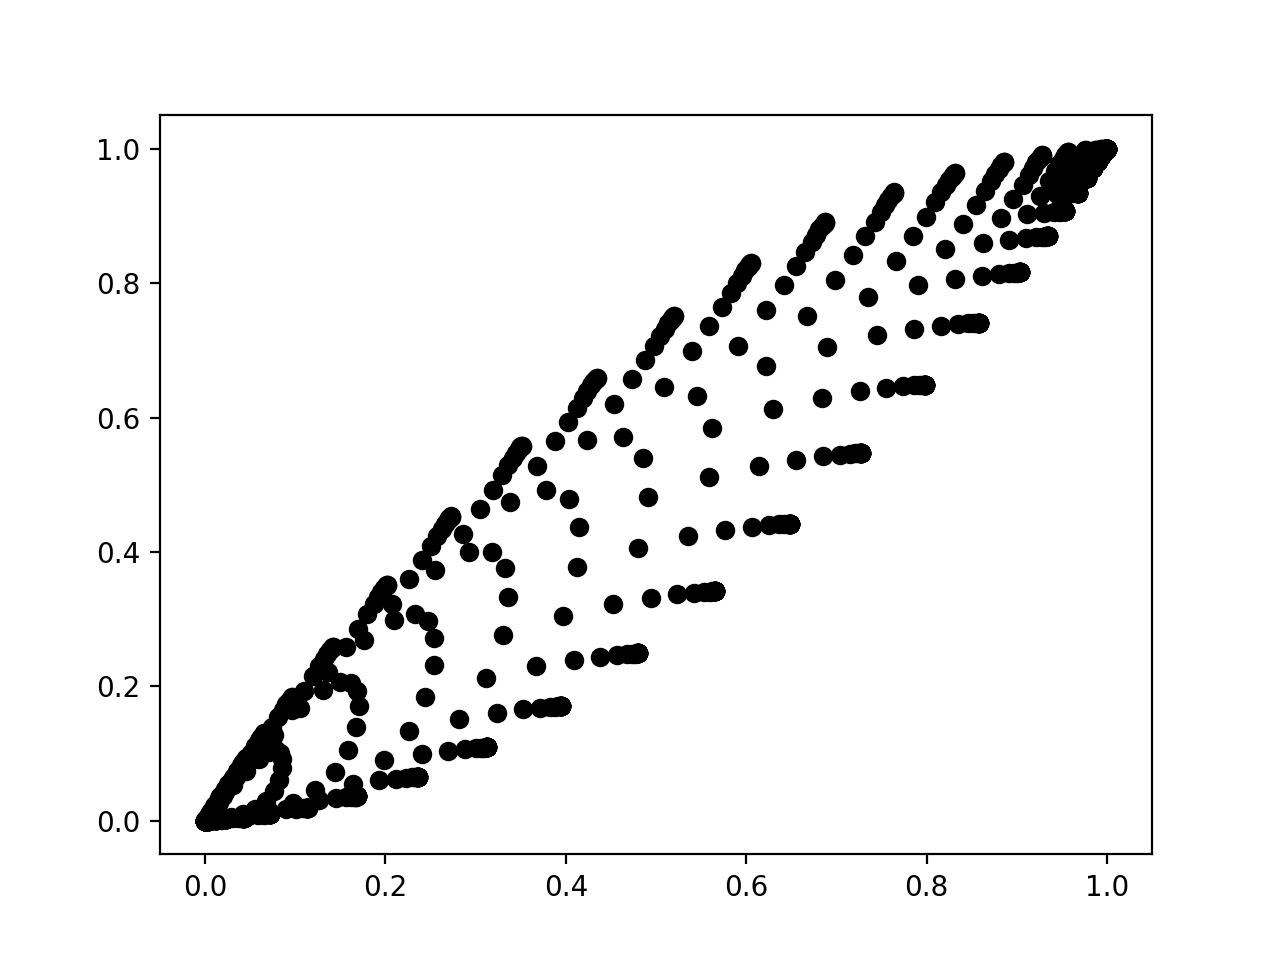

In [14]:
fig, ax = plt.subplots()
dichromat = Observer([s_cone, m_cone], min_transition_size=10)
full_colors_2d = dichromat.get_full_colors().T  

# Dichromat gamut! It's a cross section of the trichromat gamut, of course. 
plt.scatter(full_colors_2d[:, 0], full_colors_2d[:, 1], c='black')

In [15]:
dichromat.observe(trichromat.get_transition(234))

array([0.02414933, 0.04941651])

In [36]:
%%time
sorted_contrasting_pairs = sorted(contrasting_pairs, 
                                  key=lambda pair: dichromat.dist(
                                      trichromat.get_transition(intersection_indices[pair[0]]), 
                                      trichromat.get_transition(intersection_indices[pair[1]])))

CPU times: user 6min 55s, sys: 1min 38s, total: 8min 33s
Wall time: 8min 34s


In [55]:
unique_first_indices = set()
filtered_contrasting_pairs = []

for pair in sorted_contrasting_pairs:
    first_index = pair[0]
    if first_index not in unique_first_indices:
        unique_first_indices.add(first_index)
        filtered_contrasting_pairs.append(pair)


In [62]:
print(filtered_contrasting_pairs[0])

(13, 21)


In [64]:
dichromat.observe(trichromat.get_transition(intersection_indices[13]))

array([0.5760452 , 0.35988405])

In [65]:
dichromat.observe(trichromat.get_transition(intersection_indices[21]))

array([0.49526039, 0.27787468])

In [69]:
[dichromat.observe(trichromat.get_transition(intersection_indices[i])) for i in range(len(intersection_indices))]

[array([0.20820201, 0.35156825]),
 array([0.79812768, 0.64893533]),
 array([0.20821198, 0.35156911]),
 array([0.20025156, 0.34898249]),
 array([0.34488375, 0.54719794]),
 array([0.64159405, 0.7976998 ]),
 array([0.79974852, 0.65101752]),
 array([0.73093979, 0.55229569]),
 array([0.81554396, 0.73668468]),
 array([0.20489439, 0.35129747]),
 array([0.20493511, 0.35130074]),
 array([0.20481037, 0.35129088]),
 array([0.41667733, 0.21422138]),
 array([0.5760452 , 0.35988405]),
 array([0.20319524, 0.35116526]),
 array([0.20301901, 0.35115176]),
 array([0.25541405, 0.27770222]),
 array([0.79181783, 0.64843341]),
 array([0.42395488, 0.64011596]),
 array([0.20224541, 0.35109292]),
 array([0.79179786, 0.64843174]),
 array([0.49526039, 0.27787468]),
 array([0.79178789, 0.64843087]),
 array([0.79698087, 0.64884823]),
 array([0.73503473, 0.77988058]),
 array([0.21346535, 0.26825153]),
 array([0.2690603 , 0.44770432]),
 array([0.5047397 , 0.72212533]),
 array([0.79680463, 0.64883472]),
 array([0.5732

<IPython.core.display.Javascript object>


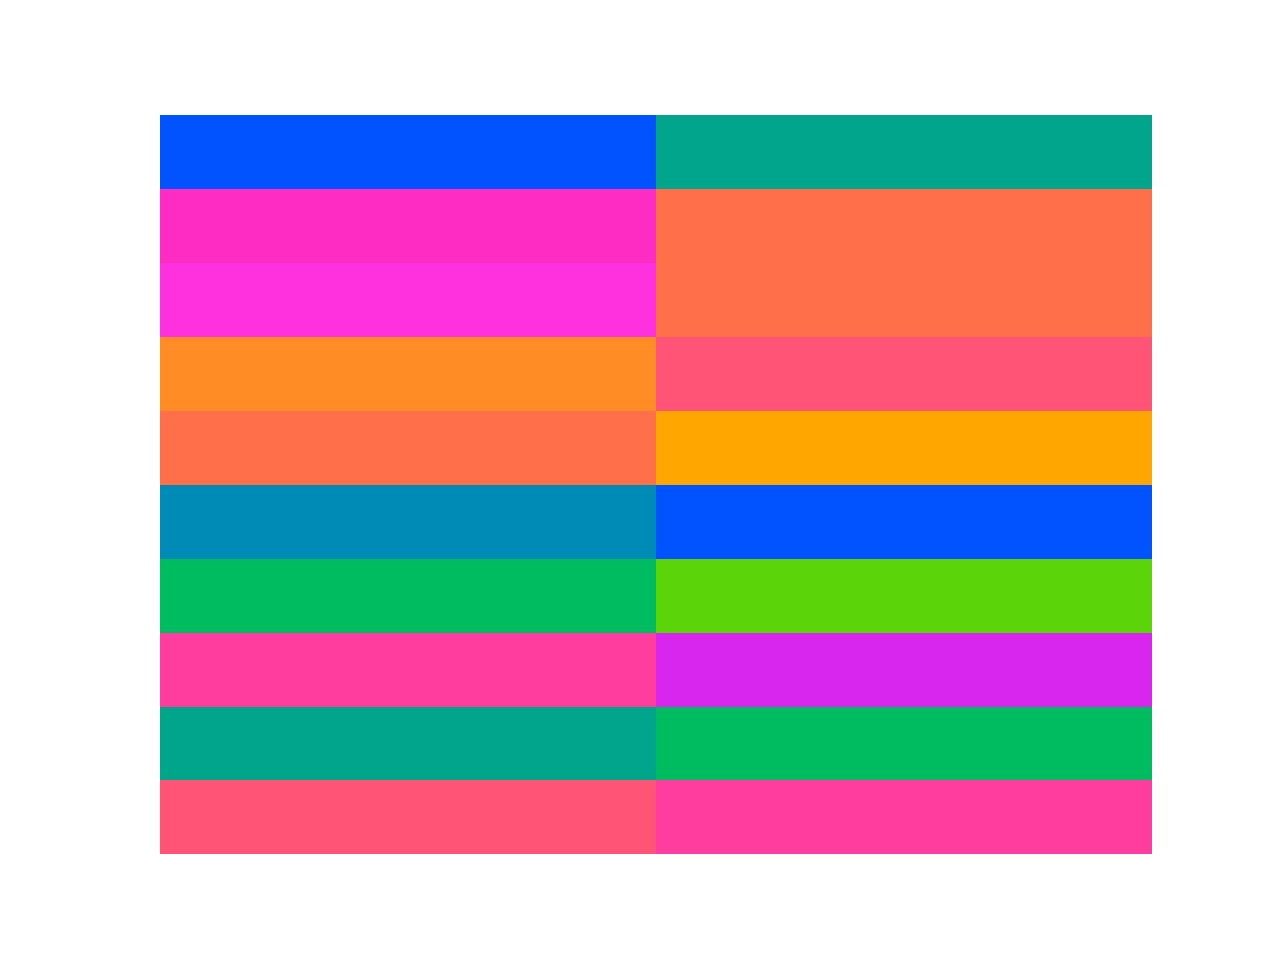

In [61]:
%matplotlib notebook
fig, ax = plt.subplots()

ax.set_xlim([0, 2])
ax.set_ylim([0, 10])

# Hide the axes
ax.axis('off')

for i, (a, b) in enumerate(filtered_contrasting_pairs[:10]):
    color_a = rgb_colors[a].reshape(-1)
    color_b = rgb_colors[b].reshape(-1)

    rect_a = plt.Rectangle((0, i), 1, 1, linewidth=1, edgecolor='none', facecolor=color_a)
    rect_b = plt.Rectangle((1, i), 1, 1, linewidth=1, edgecolor='none', facecolor=color_b)
    
    ax.add_patch(rect_a)
    ax.add_patch(rect_b)
fig.savefig("metamers.png")
plt.show()
